In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.models import Sequential
from keras.layers import Dense,  LSTM,  Dropout, SimpleRNN, Input, GRU
from keras.models import Model
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from plot_keras_history import plot_history
import tensorflow as tf
%matplotlib inline

In [2]:
import os
os.chdir('../')
path = os.getcwd()
print(path)

C:\home\program


In [3]:
data = pd.read_csv("scraping/Weight-FXandSPORT2018-2019.csv")

In [4]:
data.set_index('date')
dateTimeIndex = pd.DatetimeIndex(data['date'])
data.index = dateTimeIndex
data = data.resample('D').interpolate()
data.drop('date', axis=1)

,weight,FX
date,,
2018-01-01,-22,112.640000
2018-01-02,21,112.280000
2018-01-03,67,112.490000
2018-01-04,72,112.740000
2018-01-05,176,113.060000
...,...,...
2019-01-27,-61,109.403333
2019-01-28,-128,109.340000
2019-01-29,-198,109.380000


In [5]:
scale = pd.DataFrame(np.nan_to_num(np.log(data['FX'].values + 1)))
scale.index = data.index.values

scale['second'] = np.nan_to_num(np.log(data['weight'].values + 1))
X_day_second = data.index.values

C:\home\anaconda\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [6]:
X_orig = np.nan_to_num(np.log(data['FX'].values + 1))
X_day = data.index.values

X_orig_second = np.nan_to_num(np.log(data['weight'].values + 1))
X_day_second = data.index.values

C:\home\anaconda\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [7]:
half = round(len(X_orig)/2)

X_train = X_orig[:half-1]
X_test = X_orig[half:]
X_train_day = X_day[:half-1]
X_test_day = X_day[half:]

X_train_second = X_orig_second[:half-1]
X_test_second = X_orig_second[half:]
X_train_day_second = X_day_second[:half-1]
X_test_day_second = X_day_second[half:]

In [8]:
def show_graph(day, data, label, color="b", ylabel='stock price'):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel(ylabel)
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()

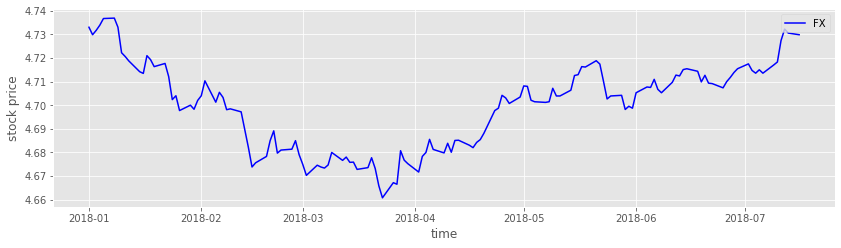

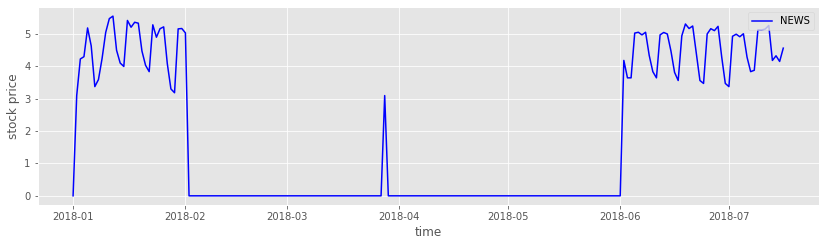

In [9]:
import pylab
plt.style.use('ggplot')
show_graph(X_train_day, X_train, 'FX')
show_graph(X_train_day_second, X_train_second, 'NEWS')

In [10]:
X_train_joint = np.vstack((X_train, X_train_second))
X_test_joint = np.vstack((X_test, X_test_second))

X_train_joint.shape

(2, 197)

In [11]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    dataX = np.zeros((data.shape[0], data.shape[1], time_steps))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - time_steps - 1):
            dataX[i][j] = data[i, j:(j + time_steps)].T
    return np.array(dataX)

In [12]:
def transform_data(original_data: np.array, 
                   inverse_option: bool, 
                   scaler: object,
                   variable_number: int,
                  ):
    data_shape = original_data.shape
    print(original_data.shape)
    data = original_data.reshape(-1, variable_number)
    print(data.shape)
    if inverse_option is True:
        print('before max {}'.format(max(data[0])))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data[0])))
    else:
        print('before max {}'.format(max(data[0])))
        print('Normalize')
        data = scaler.fit_transform(data)
        print('after max {}'.format(max(data[0])))
    data = data.reshape(data_shape)
    return data, scaler

In [13]:
def prepare_data(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x = np.swapaxes(x, 0, 1)
    x = np.swapaxes(x, 1, 2)
    return x, scaler

In [14]:
time_steps = 3
variable_number = 2

x, scaler = prepare_data(X_train_joint, time_steps, variable_number)

(2, 197)
(197, 2)
before max 4.733035556985987
Normalize
after max 0.8656676850108931
(2, 197)


In [15]:
input_dim = x.shape[-1]
timesteps = x.shape[1]

In [16]:
def create_model(input_dim,time_steps,latent_dim,model_option,batch_size=1,optimizer='adam'):
    with tf.name_scope('Model'):
        x = Input(shape=(time_steps, input_dim,))

        if model_option == 'lstm':
            with tf.name_scope('LSTM'):
                h = LSTM(latent_dim, stateful=False, return_sequences=True)(x)
        elif model_option == 'gru':
            with tf.name_scope('GRU'):
                h = GRU(latent_dim, stateful=False, return_sequences=True)(x)

        print('input_dim:', input_dim)
        with tf.name_scope('Dense'):
            out = Dense(input_dim)(h)

        model = Model(x, out)
        model.summary()

        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

In [17]:
from copy import copy 

def predict_model_show_graph(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    with timer('predict'):
        preds = model.predict(prepare_value)
    
    print('prepare_value: ', prepare_value.shape)
    print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[-1]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[:, 0, i], color='r', label='data')
        plt.plot(preds[:, 0, i], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(preds, prepare_value))
    return preds, prepare_value
    # return predict_scale, x_scale

In [18]:
predict_list = []
var_list = []

print(x.shape)
model = create_model(input_dim,time_steps=time_steps,latent_dim=120,model_option='lstm')

(197, 3, 2)
input_dim: 2
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 2)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 3, 120)            59040     
_________________________________________________________________
dense (Dense)                (None, 3, 2)              242       
Total params: 59,282
Trainable params: 59,282
Non-trainable params: 0
_________________________________________________________________


In [19]:
import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.10f}s".format(title, time.time() - t0))

Epoch 1/100
7/7 [==============================] - 2s 57ms/step - loss: 0.5125 - mse: 0.5125
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.3675 - mse: 0.3675
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 0.2480 - mse: 0.2480
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1682 - mse: 0.1682
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1332 - mse: 0.1332
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1249 - mse: 0.1249
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1021 - mse: 0.1021
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0902 - mse: 0.0902
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0813 - mse: 0.0813
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0726 - mse: 0.0726
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0659

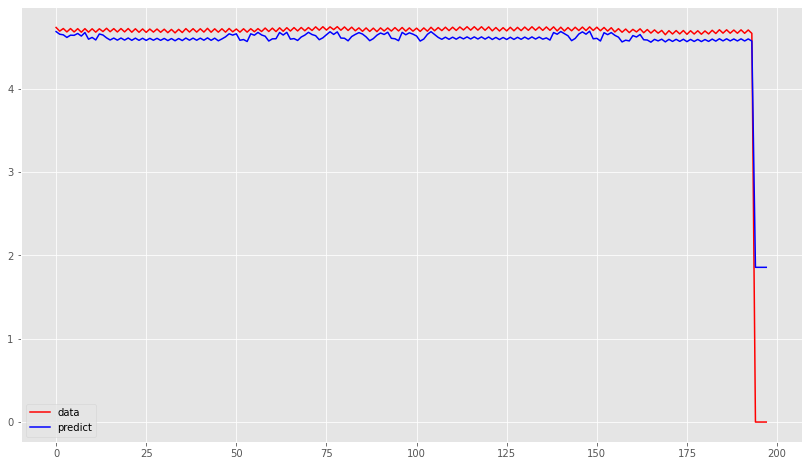

x_scale:  (198, 3, 2)


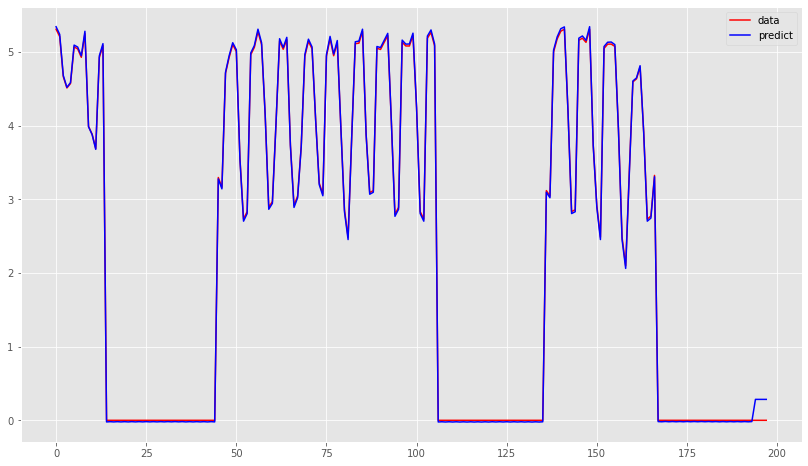

7/7 [==============================] - 0s 2ms/step - loss: 0.8480 - mse: 0.8480
model evaluate mse: [0.8480494618415833, 0.8480494618415833]


In [20]:
from pathlib import Path
from keras.callbacks import TensorBoard

log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,write_graph=True,embeddings_freq=0,)

with timer('train model simple'):
    model.fit(x, x, epochs=100, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], x_test, scaler, model,variable_number)

In [21]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.1840408481727152
rmse: 0.03817223004561089
0.11110653910916304


In [22]:
lstm_test = np.exp(x_scale_test[:, 0, 0])
lstm_pred = np.exp(predict_test[:, 0, 0])

In [23]:
F_lstm_predict = pd.DataFrame(lstm_pred)
F_lstm_predict.index = X_day_second[half:]

F_lstm_test = pd.DataFrame(lstm_test)
F_lstm_test.index = X_day[half:]

# GRU

In [24]:
model = create_model(input_dim,time_steps=time_steps,latent_dim=120,model_option='gru')

input_dim: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 2)]            0         
_________________________________________________________________
gru (GRU)                    (None, 3, 120)            44640     
_________________________________________________________________
dense_1 (Dense)              (None, 3, 2)              242       
Total params: 44,882
Trainable params: 44,882
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
7/7 [==============================] - 2s 85ms/step - loss: 0.3793 - mse: 0.3793
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1963 - mse: 0.1963
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0995 - mse: 0.0995
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0824 - mse: 0.0824
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0651 - mse: 0.0651
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0487 - mse: 0.0487
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0422 - mse: 0.0422
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0367 - mse: 0.0367
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0302 - mse: 0.0302
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0242 - mse: 0.0242
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0203

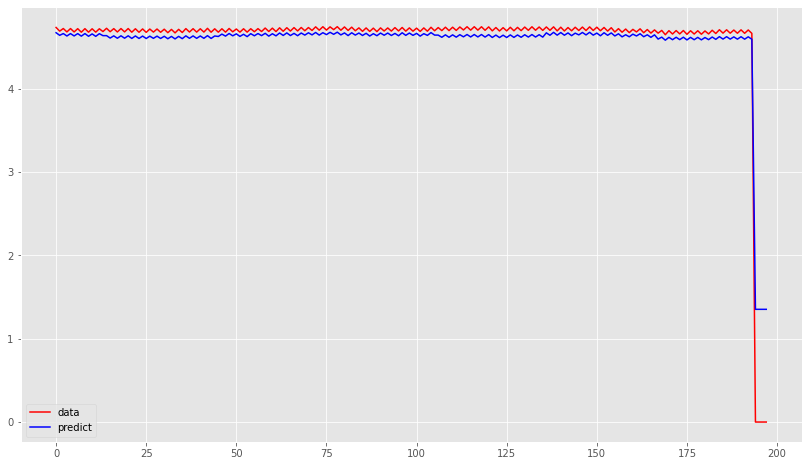

x_scale:  (198, 3, 2)


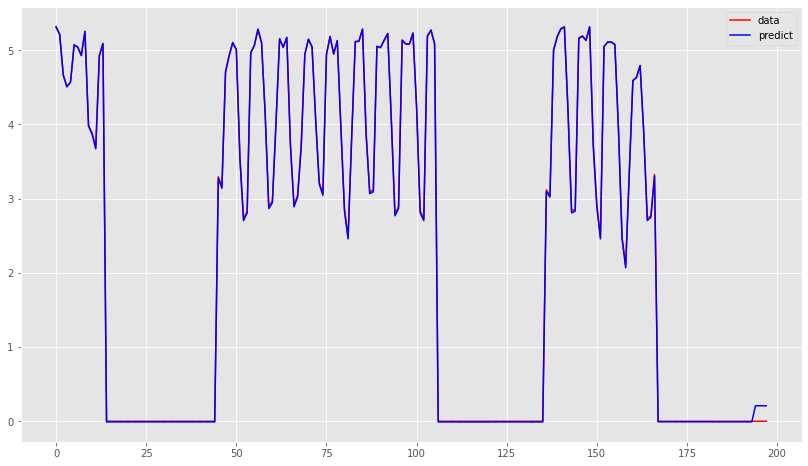

7/7 [==============================] - 0s 1ms/step - loss: 0.5580 - mse: 0.5580
model evaluate mse: [0.5580176711082458, 0.5580177307128906]


In [25]:
log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,write_graph=True,embeddings_freq=0,)

with timer('train model simple'):
    model.fit(x, x, epochs=100, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], x_test, scaler, model,variable_number)

In [26]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.12218233536804801
rmse: 0.025974798262991945
0.07407856681551998


In [27]:
gru_test = np.exp(x_scale_test[:, 0, 0])
gru_pred = np.exp(predict_test[:, 0, 0])

In [28]:
F_gru_predict = pd.DataFrame(gru_pred)
F_gru_predict.index = X_day_second[half:]

F_gru_test = pd.DataFrame(gru_test)
F_gru_test.index = X_day[half:]

# plot

In [29]:
F_lstm_test = F_lstm_test.drop(F_lstm_test.index[[len(F_lstm_test)-1,len(F_lstm_test)-2, len(F_lstm_test)-3, len(F_lstm_test)-4]])
F_lstm_predict = F_lstm_predict.drop(F_lstm_predict.index[[len(F_lstm_predict)-1,len(F_lstm_predict)-2, len(F_lstm_predict)-3, len(F_lstm_predict)-4]])
F_gru_test = F_gru_test.drop(F_gru_test.index[[len(F_gru_test)-1,len(F_gru_test)-2, len(F_gru_test)-3, len(F_gru_test)-4]])
F_gru_predict = F_gru_predict.drop(F_gru_predict.index[[len(F_gru_predict)-1,len(F_gru_predict)-2, len(F_gru_predict)-3, len(F_gru_predict)-4]])

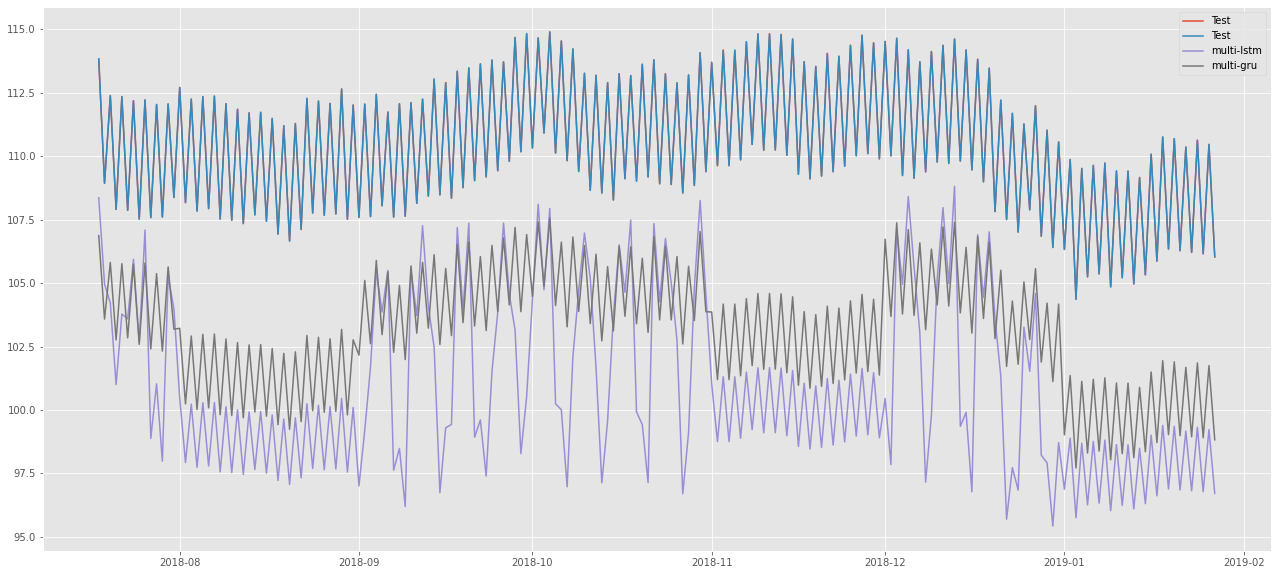

In [30]:
plt.figure(figsize=(22,10))
plt.plot(F_lstm_test, label = 'Test')
plt.plot(F_gru_test, label = 'Test')
plt.plot(F_lstm_predict, label = 'multi-lstm')
plt.plot(F_gru_predict, label = 'multi-gru')
plt.legend(loc='best')
plt.savefig('卒業論文関係/本物FX-SPORT-multi-epoch300.png')

# simple

In [31]:
L = len(data['FX'])
Y = data['FX']  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [32]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [33]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [34]:
scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [35]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [36]:
# train, testデータを定義
X_train = X[:half-1, :, :]
X_test = X[half:, :, :]
Y_train = Y[:half-1, :]
YN_test = Y[half:, :]

# lstm

In [37]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh',batch_input_shape=(None, 1, timesteps), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(10))
model.add(Dense(1))

Epoch 1/300
7/7 - 2s - loss: 0.1857 - mean_absolute_error: 0.3848
Epoch 2/300
7/7 - 0s - loss: 0.1345 - mean_absolute_error: 0.3195
Epoch 3/300
7/7 - 0s - loss: 0.0914 - mean_absolute_error: 0.2553
Epoch 4/300
7/7 - 0s - loss: 0.0607 - mean_absolute_error: 0.2041
Epoch 5/300
7/7 - 0s - loss: 0.0379 - mean_absolute_error: 0.1634
Epoch 6/300
7/7 - 0s - loss: 0.0249 - mean_absolute_error: 0.1346
Epoch 7/300
7/7 - 0s - loss: 0.0186 - mean_absolute_error: 0.1152
Epoch 8/300
7/7 - 0s - loss: 0.0160 - mean_absolute_error: 0.1038
Epoch 9/300
7/7 - 0s - loss: 0.0152 - mean_absolute_error: 0.0994
Epoch 10/300
7/7 - 0s - loss: 0.0148 - mean_absolute_error: 0.0972
Epoch 11/300
7/7 - 0s - loss: 0.0143 - mean_absolute_error: 0.0953
Epoch 12/300
7/7 - 0s - loss: 0.0136 - mean_absolute_error: 0.0932
Epoch 13/300
7/7 - 0s - loss: 0.0129 - mean_absolute_error: 0.0910
Epoch 14/300
7/7 - 0s - loss: 0.0123 - mean_absolute_error: 0.0897
Epoch 15/300
7/7 - 0s - loss: 0.0116 - mean_absolute_error: 0.0872
Epoc

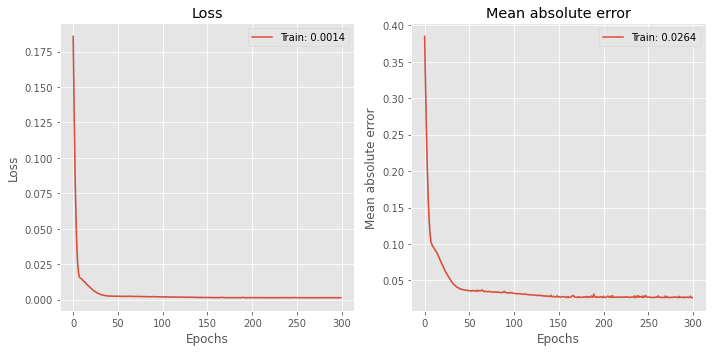

In [38]:
model.compile(loss= 'mean_squared_error', optimizer = 'adam', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=300, verbose=2).history
plot_history(history)
lstm_predict = model.predict(X_test)

# GRU

In [39]:
model = Sequential()
model.add(GRU(10, activation='tanh', batch_input_shape=(None, 1, timesteps), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(10))
model.add(Dense(1))

Epoch 1/300
7/7 - 1s - loss: 0.1677 - mean_absolute_error: 0.3665
Epoch 2/300
7/7 - 0s - loss: 0.1021 - mean_absolute_error: 0.2759
Epoch 3/300
7/7 - 0s - loss: 0.0562 - mean_absolute_error: 0.1975
Epoch 4/300
7/7 - 0s - loss: 0.0282 - mean_absolute_error: 0.1410
Epoch 5/300
7/7 - 0s - loss: 0.0158 - mean_absolute_error: 0.1056
Epoch 6/300
7/7 - 0s - loss: 0.0126 - mean_absolute_error: 0.0905
Epoch 7/300
7/7 - 0s - loss: 0.0132 - mean_absolute_error: 0.0906
Epoch 8/300
7/7 - 0s - loss: 0.0132 - mean_absolute_error: 0.0904
Epoch 9/300
7/7 - 0s - loss: 0.0123 - mean_absolute_error: 0.0870
Epoch 10/300
7/7 - 0s - loss: 0.0113 - mean_absolute_error: 0.0839
Epoch 11/300
7/7 - 0s - loss: 0.0105 - mean_absolute_error: 0.0812
Epoch 12/300
7/7 - 0s - loss: 0.0101 - mean_absolute_error: 0.0803
Epoch 13/300
7/7 - 0s - loss: 0.0096 - mean_absolute_error: 0.0787
Epoch 14/300
7/7 - 0s - loss: 0.0091 - mean_absolute_error: 0.0767
Epoch 15/300
7/7 - 0s - loss: 0.0086 - mean_absolute_error: 0.0744
Epoc

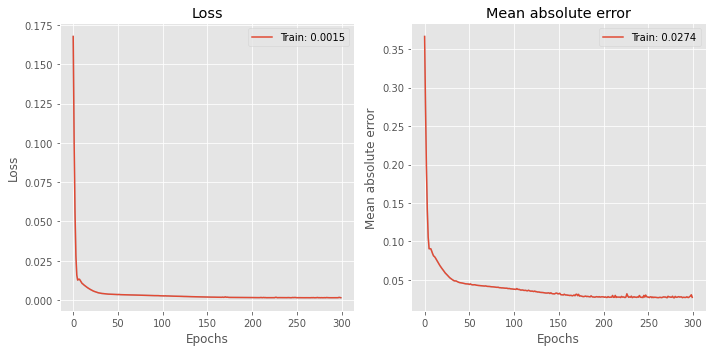

In [40]:
model.compile(loss= 'mean_squared_error', optimizer = 'adam', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=300, verbose=2).history
plot_history(history)
gru_predict = model.predict(X_test)

In [41]:
YN_test = scaler1.inverse_transform(YN_test)
YN_test = pd.DataFrame(YN_test)
YN_test.index = pd.to_datetime(data['FX'].index[half+3:])

In [42]:
lstm_predict = scaler1.inverse_transform(lstm_predict)
lstm_predict = pd.DataFrame(lstm_predict)
lstm_predict.index = pd.to_datetime(data['FX'].index[half+3:])

In [43]:
gru_predict = scaler1.inverse_transform(gru_predict)
gru_predict = pd.DataFrame(gru_predict)
gru_predict.index = pd.to_datetime(data['FX'].index[half+3:])

In [44]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(data['FX'].index[3:half+2])

# 比較

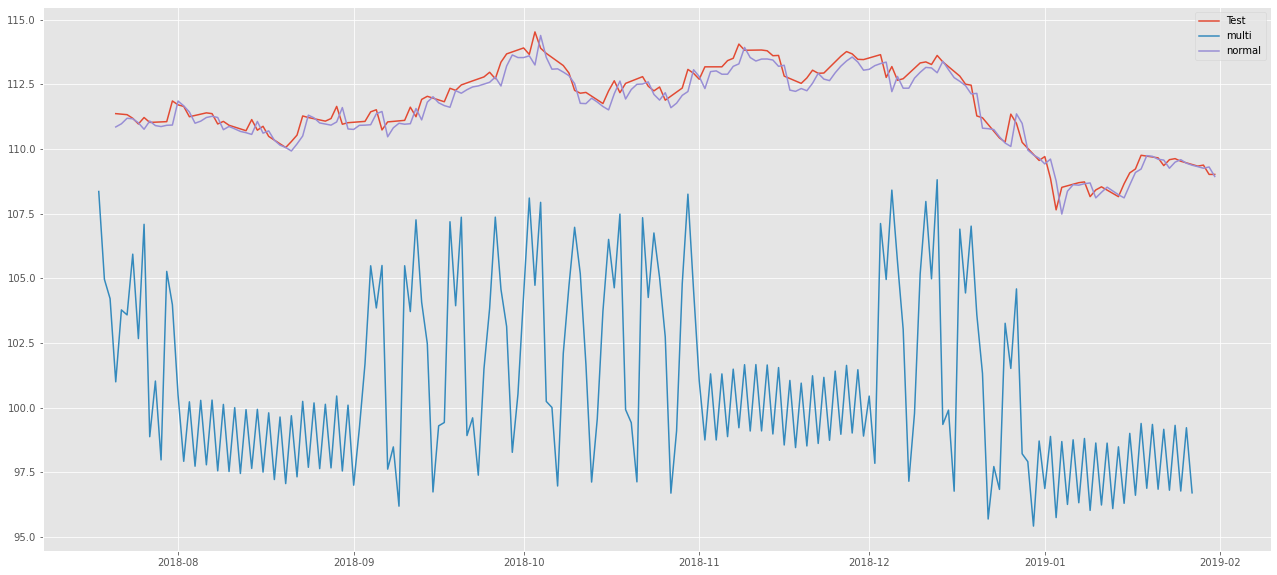

In [45]:
plt.figure(figsize=(22,10))
#plt.plot(F_lstm_test, label = 'Test')
plt.plot(YN_test, label = 'Test')
plt.plot(F_lstm_predict, label = 'multi')
plt.plot(lstm_predict, label = 'normal')
plt.legend(loc='best')
plt.savefig('卒業論文関係/本物FX-SPORT-multi-LSTM-epoch100.png')

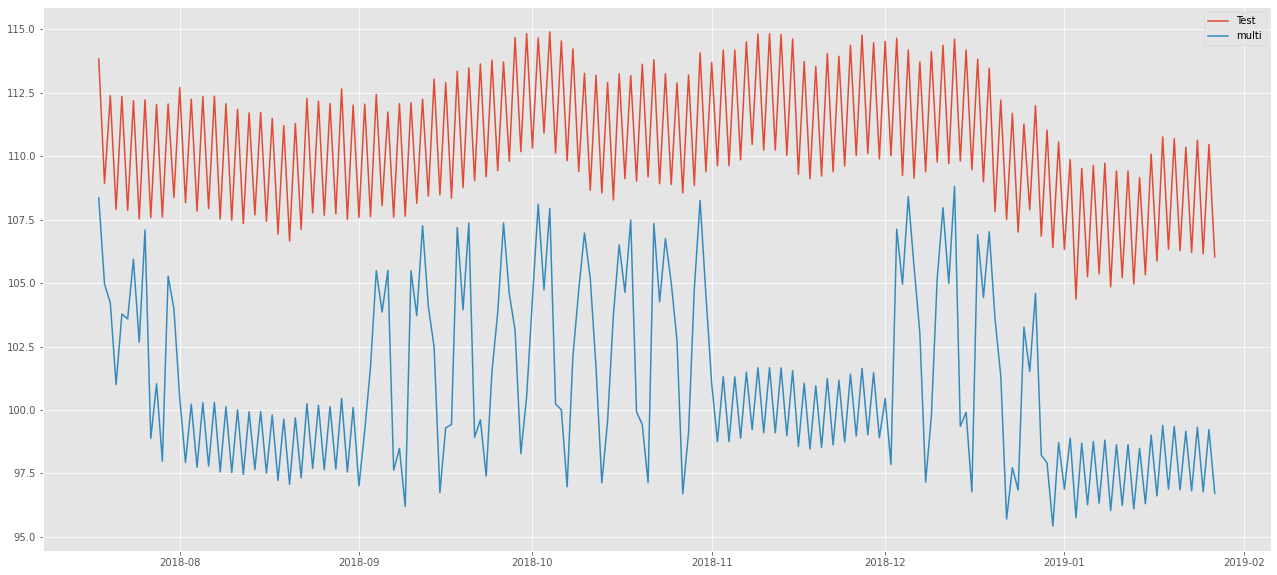

In [46]:
plt.figure(figsize=(22,10))
plt.plot(F_lstm_test, label = 'Test')
plt.plot(F_lstm_predict, label = 'multi')
plt.legend(loc='best')
#plt.savefig('画像/11-16/lstm-multi-epoch300.png')

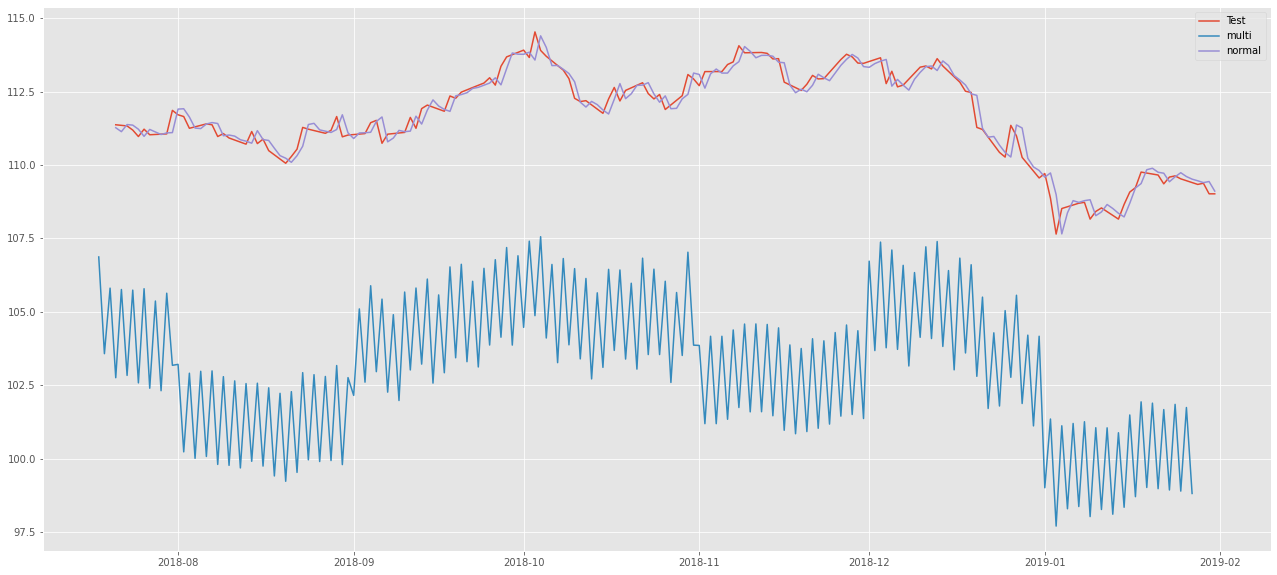

In [47]:
plt.figure(figsize=(22,10))
#plt.plot(F_gru_test, label = 'Test')
plt.plot(YN_test, label = 'Test')
plt.plot(F_gru_predict, label = 'multi')
plt.plot(gru_predict, label = 'normal')
plt.legend(loc='best')
plt.savefig('卒業論文関係/本物FX-SPORT-multi-GRU-epoch100-g.png')

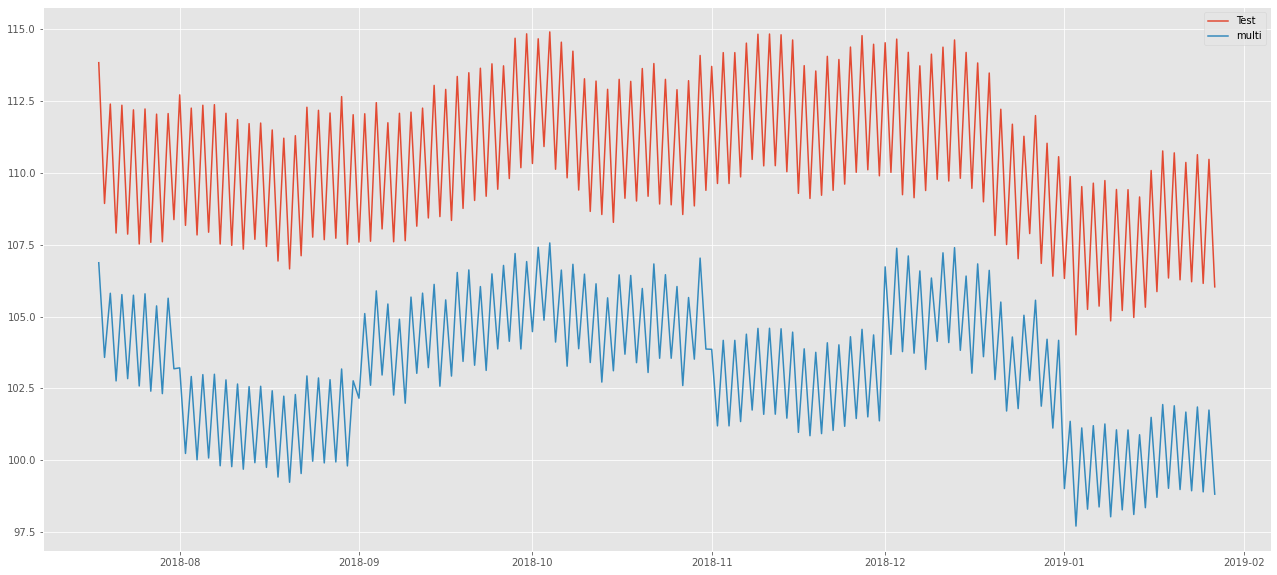

In [48]:
plt.figure(figsize=(22,10))
plt.plot(F_gru_test, label = 'Test')
plt.plot(F_gru_predict, label = 'multi')
plt.legend(loc='best')
#plt.savefig('画像/11-16/gru-multi-epoch300.png')

# RMSE

In [49]:
rmse = np.sqrt(np.average(np.subtract(F_lstm_test, F_lstm_predict) ** 2))
print('rmse:', rmse)

rmse: 10.052155849039442


In [50]:
rmse = np.sqrt(np.average(np.subtract(F_gru_test, F_gru_predict) ** 2))
print('rmse:', rmse)

rmse: 7.4469818347224175


In [51]:
rmse = np.sqrt(np.average(np.subtract(YN_test, lstm_predict) ** 2))
print('rmse:', rmse)

rmse: 0.39714594461439434


In [52]:
rmse = np.sqrt(np.average(np.subtract(YN_test, gru_predict) ** 2))
print('rmse:', rmse)

rmse: 0.33615322795396596
